# GENERATIVE ADVERSARIAL NETWORK
---

In [1]:
versioninfo() # -> v"1.11.2"

Julia Version 1.11.2
Commit 5e9a32e7af2 (2024-12-01 20:02 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 8 × Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz
  WORD_SIZE: 64
  LLVM: libLLVM-16.0.6 (ORCJIT, skylake)
Threads: 1 default, 0 interactive, 1 GC (on 8 virtual cores)
Environment:
  LD_LIBRARY_PATH = /home/mhamdi/torch/install/lib:/home/mhamdi/torch/install/lib:/home/mhamdi/torch/install/lib:
  DYLD_LIBRARY_PATH = /home/mhamdi/torch/install/lib:/home/mhamdi/torch/install/lib:/home/mhamdi/torch/install/lib:
  JULIA_NUM_THREADS = 8


In [2]:
using Pkg; pkg"activate ."

  Activating project at `~/Work/git-repos/AI-ML-DL/jlai/Codes/Julia/Part-3/gan`


In [3]:
using Flux # v"0.16.0"
using Images: Gray
using ProgressMeter

**Generator:** noise vector -> synthetic sample

In [4]:
function generator(; latent_dim=16, img_shape=(28,28,1,1))
    return Chain(
        Dense(latent_dim, 128, relu),
        Dense(128, 256, relu),
        Dense(256, prod(img_shape), tanh),
        x -> reshape(x, img_shape)
    )
end

generator (generic function with 1 method)

**Discriminator:** sample -> score indicating the probability that the sample is real.

In [5]:
function discriminator(; img_shape=(28,28,1,1))
    return Chain(
        x -> reshape(x, :, size(x, 4)),
        Dense(prod(img_shape), 256, relu),
        Dense(256, 128, relu),
        Dense(128, 1)
    )
end

discriminator (generic function with 1 method)

Loss function

In [6]:
bce_loss(y_true, y_pred) = Flux.logitbinarycrossentropy(y_pred, y_true)

bce_loss (generic function with 1 method)

Training function

In [7]:
function train_gan(gen, disc, gen_st, disc_st; n_epochs=16, latent_dim=16)
    @showprogress for epoch in 1:n_epochs

        ## Train the discriminator `disc`
        noise = randn(Float32, latent_dim, 1)
        fake_imgs = gen(noise) # pass the noise through the generator to get a synthetic sample
        real_imgs = rand(Float32, size(fake_imgs)...)

        disc_loss(m) = bce_loss(ones(Float32, 1, 1), m(real_imgs)) + 
                        bce_loss(zeros(Float32, 1, 1), m(fake_imgs)) # compute the loss for the real and synthetic samples
        grads = gradient(m -> disc_loss(m), disc)
        Flux.update!(disc_st, Flux.trainable(disc), grads[1]) # update the discriminator weights

        ## Train the generator `gen`
        noise = randn(Float32, latent_dim, 1)
        gen_loss(m) = bce_loss( ones(Float32, 1, 1), σ.(disc(m(noise))) ) # compute the loss for the synthetic samples
        grads = gradient(m -> gen_loss(m), gen)
        Flux.update!(gen_st, Flux.trainable(gen), grads[1]) # update the generator weights

        println("Epoch $(epoch): Discriminator loss = $(disc_loss), Generator loss = $(gen_loss)")
        sleep(.1)
    end
end

train_gan (generic function with 1 method)

Setup the GAN

In [8]:
gen = generator()

Chain(
  Dense(16 => 128, relu),               # 2_176 parameters
  Dense(128 => 256, relu),              # 33_024 parameters
  Dense(256 => 784, tanh),              # 201_488 parameters
  var"#4#5"{NTuple{4, Int64}}((28, 28, 1, 1)),
)                   # Total: 6 arrays, 236_688 parameters, 924.898 KiB.

In [9]:
disc = discriminator()

Chain(
  var"#7#8"(),
  Dense(784 => 256, relu),              # 200_960 parameters
  Dense(256 => 128, relu),              # 32_896 parameters
  Dense(128 => 1),                      # 129 parameters
)                   # Total: 6 arrays, 233_985 parameters, 914.309 KiB.

In [10]:
gen_opt = Adam(0.001); gen_st = Flux.setup(gen_opt, gen)
disc_opt = Adam(0.0002); disc_st = Flux.setup(disc_opt, disc)

(layers = ((), (weight = Leaf(Adam(0.0002, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam(0.0002, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999))), σ = ()), (weight = Leaf(Adam(0.0002, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam(0.0002, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0

Train the GAN

In [11]:
train_gan(gen, disc, gen_st, disc_st)

Epoch 1: Discriminator loss = disc_loss, Generator loss = gen_loss
Epoch 2: Discriminator loss = disc_loss, Generator loss = gen_loss


Progress:  12%|█████▏                                   |  ETA: 0:01:22

Epoch 3: Discriminator loss = disc_loss, Generator loss = gen_loss
Epoch 4: Discriminator loss = disc_loss, Generator loss = gen_loss
Epoch 5: Discriminator loss = disc_loss, Generator loss = gen_loss
Epoch 6: Discriminator loss = disc_loss, Generator loss = gen_loss
Epoch 7: Discriminator loss = disc_loss, Generator loss = gen_loss
Epoch 8: Discriminator loss = disc_loss, Generator loss = gen_loss
Epoch 9: Discriminator loss = disc_loss, Generator loss = gen_loss


Progress:  56%|███████████████████████                  |  ETA: 0:00:10

Epoch 10: Discriminator loss = disc_loss, Generator loss = gen_loss


Progress:  62%|█████████████████████████▋               |  ETA: 0:00:08

Epoch 11: Discriminator loss = disc_loss, Generator loss = gen_loss


Progress:  69%|████████████████████████████▎            |  ETA: 0:00:06

Epoch 12: Discriminator loss = disc_loss, Generator loss = gen_loss


Progress:  75%|██████████████████████████████▊          |  ETA: 0:00:05

Epoch 13: Discriminator loss = disc_loss, Generator loss = gen_loss


Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:03

Epoch 14: Discriminator loss = disc_loss, Generator loss = gen_loss


Progress:  88%|███████████████████████████████████▉     |  ETA: 0:00:02

Epoch 15: Discriminator loss = disc_loss, Generator loss = gen_loss


Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:01

Epoch 16: Discriminator loss = disc_loss, Generator loss = gen_loss


Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


Generate and plot some images

In [12]:
latent_dim = 16
noise = randn(Float32, latent_dim, 16)
generated_images = [ gen(noise[:, i]) for i in 1:16 ];

In [13]:
using Plots

In [14]:
plot_images = [ plot(Gray.(generated_images[i])[:,:,1,1]) for i in 1:16 ]
titles = reshape([string(i) for i in 1:16], 1, :);

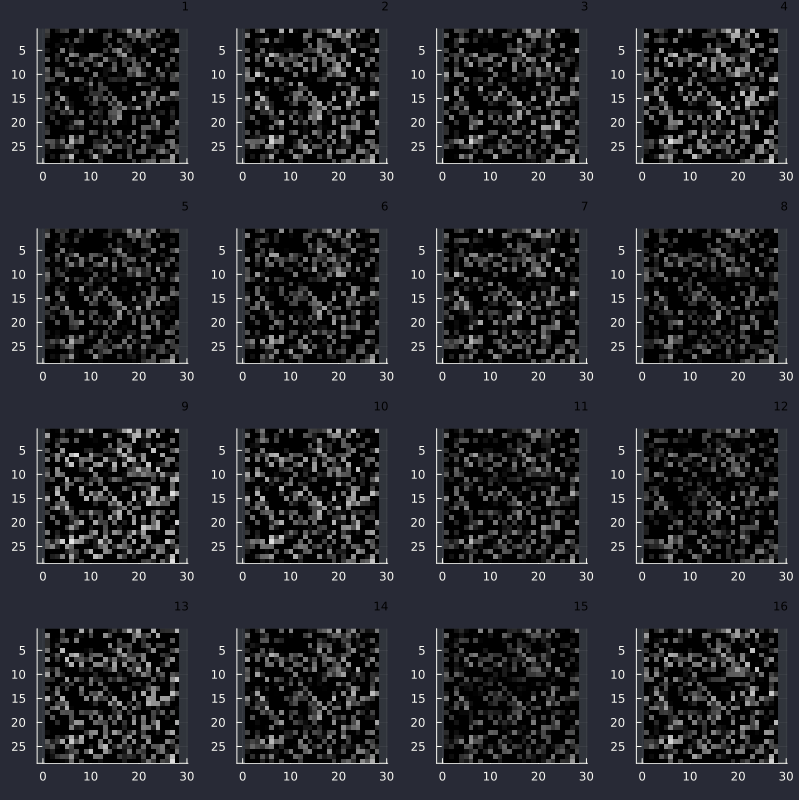

In [15]:
plot(
    plot_images...,
    layout = (4, 4), 
    title = titles, titleloc=:right, titlefont=font(8),
    size = (800, 800)
)